In [2]:
# Import modules

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
import time
import optuna
from dask.distributed import Client,  wait

In [3]:
optimization_time_in_seconds = -time.time()

In [4]:
def study_wrapper(study, n_trials):
    # Load and prepare data

    df = pd.read_csv("/app/story/titanic-lg.csv") # loading data from volume

    label_encoder = LabelEncoder()
    df['Sex'] = label_encoder.fit_transform(df['Sex']) # category encoding
    df['Embarked'] = label_encoder.fit_transform(df['Embarked']) # category encoding
    df.drop(columns=["Cabin","Name","Ticket"],inplace=True) # deleting unnecessary columns
    df["Age"].fillna(df["Age"].mean(), inplace=True) # filling null values
    df["Fare"].fillna(df["Fare"].mean(),inplace=True) # filling null values

    # Split data to train and test sets

    x=df.drop(columns=["Survived"])
    y=df["Survived"]

    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

    # Defining objective function
    
    def objective(trial: optuna.Trial):
        md = trial.suggest_int('max_depth', 2, 64)
        mi = trial.suggest_int('min_inst', 1, 32)
        
        clf =  DecisionTreeClassifier(max_depth=md, min_samples_leaf=mi, random_state=1, )
        clf.fit(x_train, y_train)

        y_pred = clf.predict(x_test)
        
        return f1_score(y_test, y_pred)
    
    study.optimize(objective, n_trials=n_trials)


In [5]:
n_workers = 10 # broj worker nodova
n_trials = 1000 # broj pokusaja za pronalazenje najboljih parametara

In [6]:
# Split trials to nodes

if n_trials <= n_workers:
    trials_per_node = [1 for i in range(n_trials)]
else:
    whole_trials=n_trials // n_workers
    partional_trials=n_trials % n_workers
    trials_per_node = [whole_trials + (1 if i < partional_trials else 0) for i in range(0, n_workers)]

In [7]:
client = Client("tcp://<server_ip>:<port>")

c:\Users\ljmatovic\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\client.py:1617: VersionMismatchWarning: Mismatched versions found

+---------+----------------+-----------------+-----------------+
| Package | Client         | Scheduler       | Workers         |
+---------+----------------+-----------------+-----------------+
| lz4     | None           | 4.3.3           | 4.3.3           |
| python  | 3.10.0.final.0 | 3.10.12.final.0 | 3.10.12.final.0 |
| toolz   | 0.12.1         | 0.12.0          | 0.12.0          |
+---------+----------------+-----------------+-----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [8]:
backend_storage = optuna.storages.InMemoryStorage()
dask_storage = optuna.integration.dask.DaskStorage(storage=backend_storage, client=client)
study = optuna.create_study(study_name="DecisionTreeClassifier", direction='maximize', storage=dask_storage)

C:\Users\ljmatovic\AppData\Local\Temp\ipykernel_17312\56268600.py:2: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  dask_storage = optuna.integration.dask.DaskStorage(storage=backend_storage, client=client)


In [9]:
futures = []
print(trials_per_node)
start=0
for i in trials_per_node:
    iter_range = (start + 1, start+i)
    start+=i
    futures.append(
        {
            "range": iter_range,
            "futures": [
                client.submit(study_wrapper, study, n_trials=i, pure=False)
            ],
        }
    )
for partition in futures:
    iter_range = partition["range"]
    print(f"Testing hyperparameter combinations {iter_range[0]}..{iter_range[1]}")
    _ = wait(partition["futures"])

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Testing hyperparameter combinations 1..100
Testing hyperparameter combinations 101..200
Testing hyperparameter combinations 201..300
Testing hyperparameter combinations 301..400
Testing hyperparameter combinations 401..500
Testing hyperparameter combinations 501..600
Testing hyperparameter combinations 601..700
Testing hyperparameter combinations 701..800
Testing hyperparameter combinations 801..900
Testing hyperparameter combinations 901..1000


In [10]:
optimization_time_in_seconds += time.time()

In [11]:
print("Best params:", study.best_params)
print("Best value:", study.best_value)
minutes = int(optimization_time_in_seconds) // 60
seconds = int(optimization_time_in_seconds)
seconds = seconds % 60 + (optimization_time_in_seconds - int(optimization_time_in_seconds))    
print("Optimization time: {} m {} s".format(minutes, seconds))

Best params: {'max_depth': 13, 'min_inst': 17}
Best value: 0.8346708590022485
Optimization time: 8 m 22.99800729751587 s


In [15]:
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
)

C:\Users\ljmatovic\AppData\Local\Temp\ipykernel_17312\364689380.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


<Axes: title={'center': 'Titanic DecisionTreeClassifier Optimization history'}, xlabel='Trial', ylabel='Objective Value'>

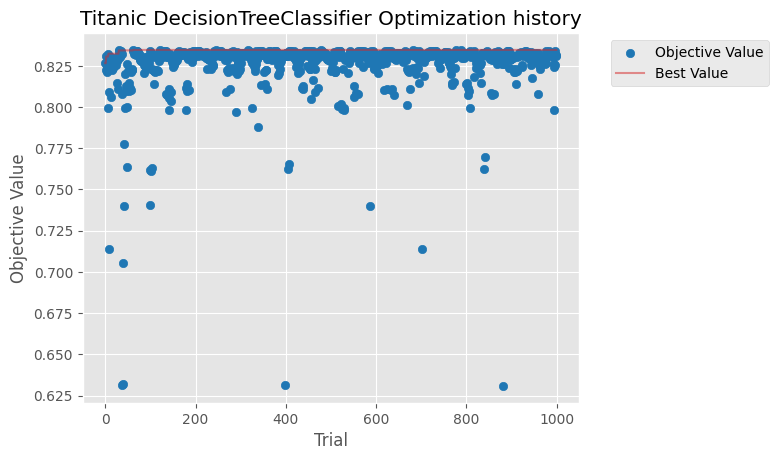

In [19]:
ax = plot_optimization_history(study)
ax.set_title("Titanic DecisionTreeClassifier Optimization history")
ax

C:\Users\ljmatovic\AppData\Local\Temp\ipykernel_17312\1889527835.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_param_importances(study)


<Axes: title={'left': 'Titanic DecisionTreeClassifier Hyperparameter Importance'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

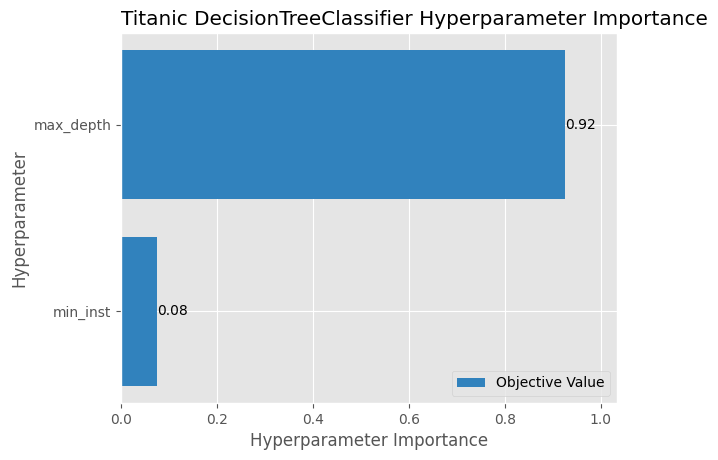

In [24]:
ax = plot_param_importances(study)
ax.set_title("Titanic DecisionTreeClassifier Hyperparameter Importance", loc="left")
ax